<a href="https://colab.research.google.com/github/glorivaas/Risk_Measures/blob/main/PROJECT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **FINAL PROJECT**
# **American Option Portfolio Value-at-Risk (VaR)**

### **INTRODUCTION**
  ▶ What is an **option**?
  
  An option is a financial contract that gives someone the right (but not the obligation) to buy or sell something in the future, like a stock.

  - A call option = right to buy

  - A put option = right to sell


▶ What is an **American Option**?

There are two main types:

  - European option: can only be exercised at the end

  - American option: can be exercised at any time before or on the expiration date


▶  Why are American Options **harder to value**?

Because we do not know when the holder will choose to exercise it. We need a smart way to decide if holding the option is better than using it right now.


▶  We introduce: **Longstaff-Schwartz Algorithm**

This algorithm helps us estimate the best time to exercise an American option.
It works like this:
  
  1. Simulate multiple price paths for the underlying stock.

  2. At each time step, calculate:

    - The immediate payoff from exercising

    - The expected value of holding it longer (using regression)

    - Exercise the option if it is better than holding it.

  3. Repeat for many paths and average results to estimate the option’s value.

▶ **Portfolio** VaR calculation

We will follow this steps in this project:

  1. Simulating portfolio values under many market conditions.

  2. Calculating the distribution of possible profits and losses (P&L).

  3. Taking the 5th percentile (for 95% VaR) — this is the estimated worst loss.

**DATA**:

We will use SPY ticker, because:

- It’s a real security

- You can get actual option prices for validation

- American options exist and trade on SPY (but not on ^GSPC)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


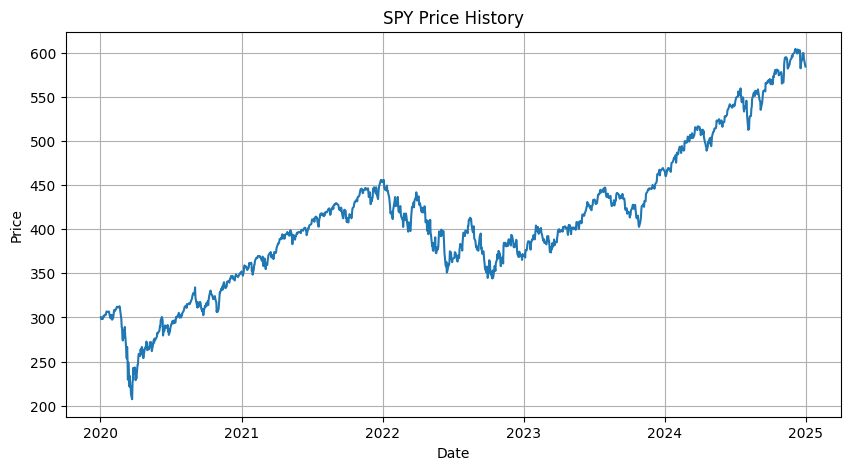

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ticker = 'SPY'
start_date = '2020-01-01'
end_date = '2025-01-01'

spy_data = yf.download(ticker, start=start_date, end=end_date)
spy_data = spy_data[['Close']].rename(columns={'Close': 'Price'})

plt.figure(figsize=(10, 5))
plt.plot(spy_data.index, spy_data['Price'])
plt.title('SPY Price History')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()


Annualized Mean Return (mu): 0.1335
Annualized Volatility (sigma): 0.2108


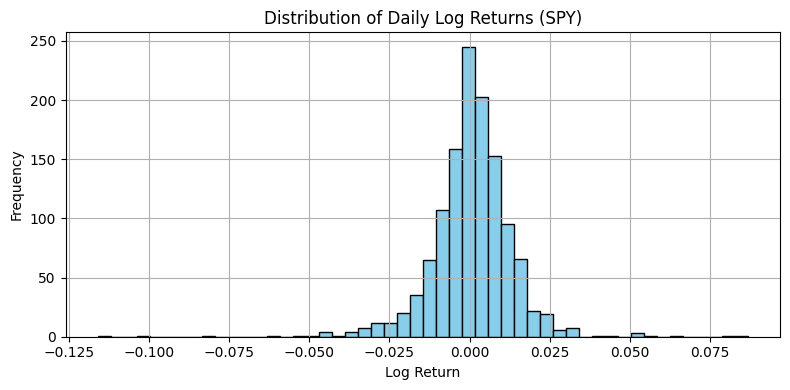

In [2]:
spy_data['LogReturn'] = np.log(spy_data['Price'] / spy_data['Price'].shift(1))
spy_data.dropna(inplace=True)

mu_daily = spy_data['LogReturn'].mean()
sigma_daily = spy_data['LogReturn'].std()

mu_annual = mu_daily * 252
sigma_annual = sigma_daily * np.sqrt(252)

print(f"Annualized Mean Return (mu): {mu_annual:.4f}")
print(f"Annualized Volatility (sigma): {sigma_annual:.4f}")

plt.figure(figsize=(8, 4))
plt.hist(spy_data['LogReturn'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Daily Log Returns (SPY)")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

#**PRELIMINAR ANALYSIS**
On the one hand, a mean return of aprox 13.35% is a reasonable average annual return as the long term average for the S&P 500 is usually around 7%–10% (after inflation). Also some recent 5-year windows (like post-COVID recovery) have been higher — so 13% is very plausible.

On the other hand, volatility is of aprox 21.08%. This is also a realistic result, as SPY's volatility usually ranges between 15%–25% annually. Events like COVID crash (2020), inflation spikes (2022) and tech growth rebound (2023–2024) all contribute to volatility in your 5-year window.

#**IMPLEMENTATION**
**Monte Carlo Simulation (using GBM)**

We simulate future asset prices by generating multiple random paths based on the Geometric Brownian Motion (GBM) model:

$$
S_{t+\Delta t} = S_t \cdot \exp\left[\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t + \sigma \cdot \sqrt{\Delta t} \cdot Z_t\right]
$$

Where:
- $ S_t $: asset price at time $ t $
- $ \mu $: expected return
- $ \sigma $: volatility
- $ \Delta t $: time step (1/252 for daily simulation)
- $ Z_t \sim \mathcal{N}(0, 1) $: standard normal random variable

This method generates multiple possible price paths to estimate the future distribution of asset prices.

In [23]:
import numpy as np
import scipy.stats as sts
from typing import Tuple


class MonteCarloOptionPricing:
    def __init__(self, r, S0: float, K: float, T: float, sigma: float, div_yield: float = 0.0,
                 simulation_rounds: int = 10000, no_of_slices: int = 4, fix_random_seed: bool or int = False):
        """
        An important reminder, by default the implementation assumes constant interest rate and volatility.
        To allow for stochastic interest rate and vol, run Vasicek/CIR for stochastic interest rate and
        run Heston for stochastic volatility before you run price simulation.

        :param S0: current price of the underlying asset (e.g. stock)
        :param K: exercise price
        :param T: time to maturity, in years, a float number
        :param r: interest rate, by default we assume constant interest rate model
        :param sigma: volatility (in standard deviation) of the asset annual returns
        :param div_yield: annual dividend yield
        :param simulation_rounds: in general, monte carlo option pricing requires many simulations
        :param no_of_slices: between time 0 and time T, the number of slices PER YEAR, e.g. 252 if trading days are required
        :param fix_random_seed: boolean or integer
        """
        assert sigma >= 0, 'volatility cannot be less than zero'
        assert S0 >= 0, 'initial stock price cannot be less than zero'
        assert T >= 0, 'time to maturity cannot be less than zero'
        assert div_yield >= 0, 'dividend yield cannot be less than zero'
        assert no_of_slices >= 0, 'no of slices per year cannot be less than zero'
        assert simulation_rounds >= 0, 'simulation rounds cannot be less than zero'

        self.S0 = float(S0)
        self.K = float(K)
        self.T = float(T)
        self.div_yield = float(div_yield)

        self.no_of_slices = int(no_of_slices)
        self.simulation_rounds = int(simulation_rounds)

        self._dt = self.T / self.no_of_slices

        self.mue = r  # under risk-neutral measure, asset expected return = risk-free rate
        self.r = np.full((self.simulation_rounds, self.no_of_slices), r * self._dt)
        self.discount_table = np.exp(np.cumsum(-self.r, axis=1))

        self.sigma = np.full((self.simulation_rounds, self.no_of_slices), sigma)

        self.terminal_prices = []

        self.z_t = np.random.standard_normal((self.simulation_rounds, self.no_of_slices))

        if type(fix_random_seed) is bool:
            if fix_random_seed:
                np.random.seed(15000)
        elif type(fix_random_seed) is int:
            np.random.seed(fix_random_seed)


    def stock_price_simulation(self) -> np.ndarray:
        self.exp_mean = (self.mue - self.div_yield - (self.sigma ** 2.0) * 0.5) * self._dt
        self.exp_diffusion = self.sigma * np.sqrt(self._dt)

        self.price_array = np.zeros((self.simulation_rounds, self.no_of_slices))
        self.price_array[:, 0] = self.S0

        for i in range(1, self.no_of_slices):
            self.price_array[:, i] = self.price_array[:, i - 1] * np.exp(
                self.exp_mean[:, i - 1] + self.exp_diffusion[:, i - 1] * self.z_t[:, i - 1]
            )

        self.terminal_prices = self.price_array[:, -1]
        self.stock_price_expectation = np.average(self.terminal_prices)

        print('-' * 64)
        print(
            " Number of simulations %4.1i \n S0 %4.1f \n K %2.1f \n Maximum Stock price %4.2f \n"
            " Minimum Stock price %4.2f \n Average stock price %4.3f " % (
                self.simulation_rounds, self.S0, self.K, np.max(self.terminal_prices),
                np.min(self.terminal_prices), self.stock_price_expectation
            )
        )
        print('-' * 64)

        return self.stock_price_expectation

    def european_call(self) -> Tuple[float, float]:
        assert len(self.terminal_prices) != 0, 'Please simulate the stock price first'

        self.terminal_profit = np.maximum((self.terminal_prices - self.K), 0.0)

        self.expectation = np.average(self.terminal_profit * np.exp(-np.sum(self.r, axis=1)))

        print('-' * 64)
        print(
            " European call monte carlo \n S0 %4.1f \n K %2.1f \n"
            " Call Option Value %4.3f \n " % (
                self.S0, self.K, self.expectation
            )
        )
        print('-' * 64)

        return self.expectation

    def european_put(self, empirical_call: float or None = None) -> float:
        """
        Use put call parity (incl. continuous dividend) to calculate the put option value
        :param empirical_call: can be calculated or observed call option value
        :return: put option value
        """
        if empirical_call is None:
            self.european_call_value = self.european_call()
        else:
            self.european_call_value = empirical_call

        self.put_value = self.european_call_value + np.exp(-np.sum(self.r, axis=1)) * self.K - np.exp(
            -self.div_yield * self.T) * self.S0

        return self.put_value


    def american_option_longstaff_schwartz(self, poly_degree: int = 2, option_type: str = 'call') -> float:
        """
        American option pricing using Longstaff-Schwartz method.

        :param poly_degree: degree of polynomial for regression (default=2)
        :param option_type: 'call' or 'put'
        """
        assert option_type in ['call', 'put'], "option_type must be either 'call' or 'put'"
        assert len(self.terminal_prices) != 0, "Please simulate stock prices first"

        # Compute intrinsic value
        if option_type == 'call':
            self.intrinsic_val = np.maximum(self.price_array - self.K, 0.0)
        else:
            self.intrinsic_val = np.maximum(self.K - self.price_array, 0.0)

        # Final cashflow = intrinsic value at maturity
        cf = self.intrinsic_val[:, -1]
        stopping_rule = np.zeros_like(self.price_array)
        stopping_rule[:, -1] = (cf > 0).astype(int)

        # Track which paths have already exercised
        exercised = np.zeros(self.simulation_rounds, dtype=bool)

        # Backward induction
        for t in range(self.no_of_slices - 2, 0, -1):
            # Discount cashflows only for paths still alive
            cf[~exercised] *= np.exp(-self.r[~exercised, t + 1])

            itm_path = np.where((self.intrinsic_val[:, t] > 0) & (~exercised))[0]
            if len(itm_path) > 5:
                Y = cf[itm_path]
                X = self.price_array[itm_path, t]
                coeffs = np.polyfit(X, Y, deg=poly_degree)
                continuation_val = np.polyval(coeffs, X)
            else:
                continuation_val = np.zeros(len(itm_path))

            # Compare continuation value vs. immediate exercise
            exercise_now = self.intrinsic_val[itm_path, t] > (continuation_val + 1e-6)
            exercised_indices = itm_path[exercise_now]

            # Update cashflows and stopping rule for exercised paths
            cf[exercised_indices] = self.intrinsic_val[exercised_indices, t]
            exercised[exercised_indices] = True
            stopping_rule[exercised_indices, t] = 1
            stopping_rule[exercised_indices, t + 1:] = 0

        # Calculate discounted payoff
        simulation_vals = (self.intrinsic_val * stopping_rule * self.discount_table).sum(axis=1)
        self.expectation = np.mean(simulation_vals)

        print('-' * 64)
        print(
            f" American {option_type} Longstaff-Schwartz pricing\n"
            f" Polynomial degree = {poly_degree}\n"
            f" S0 = {self.S0:.2f}, K = {self.K:.2f}, Value = {self.expectation:.4f}"
        )
        print('-' * 64)

        return self.expectation

# **EXPERIMENT 1: Call Options looping over different strike prices**

----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 560.0 
 Maximum Stock price 1344.46 
 Minimum Stock price 222.74 
 Average stock price 601.858 
----------------------------------------------------------------
----------------------------------------------------------------
 European call monte carlo 
 S0 584.3 
 K 560.0 
 Call Option Value 69.044 
 
----------------------------------------------------------------
----------------------------------------------------------------
 American call Longstaff-Schwartz pricing
 Polynomial degree = 2
 S0 = 584.32, K = 560.00, Value = 71.8045
----------------------------------------------------------------
----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 570.0 
 Maximum Stock price 1572.38 
 Minimum Stock price 208.57 
 Average stock price 601.527 
----------------------------------------------------------------
---------------

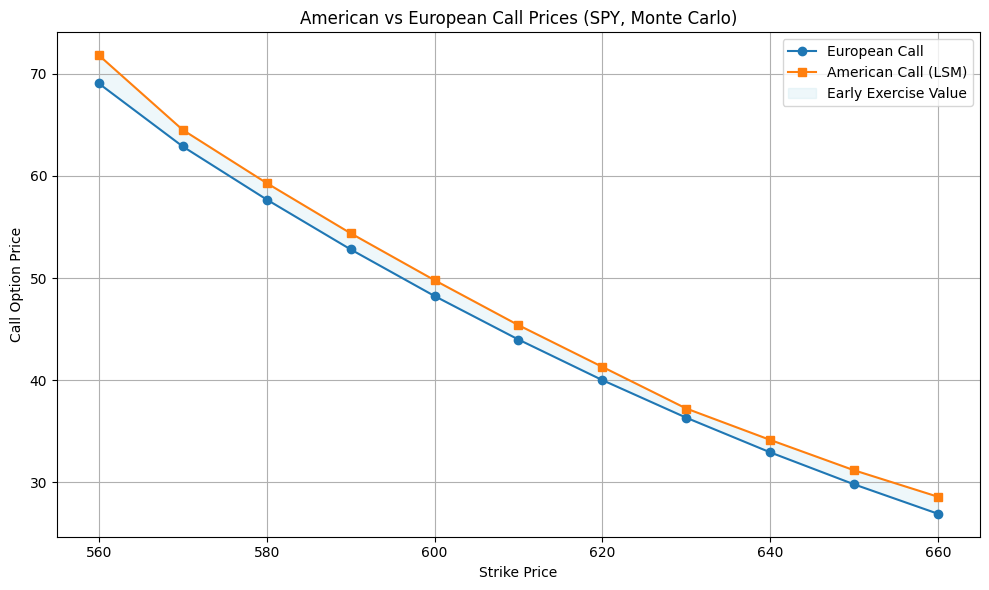

In [24]:
import numpy as np
import matplotlib.pyplot as plt

S0 = spy_data['Price'].iloc[-1]
S0 = S0.values[0]
T = 1
r = 0.05
sigma = sigma_annual
div_yield = 0.02
sim_rounds = 50000
time_slices = 252

# === Strike range ===
strike_range = np.arange(560, 670, 10)

european_calls = []
american_calls = []

# === Loop over strikes ===
for K in strike_range:
    # Create new engine for each K
    engine = MonteCarloOptionPricing(
        r=r, S0=S0, K=K, T=T, sigma=sigma,
        div_yield=div_yield,
        simulation_rounds=sim_rounds,
        no_of_slices=time_slices,
        fix_random_seed=42
    )

    # Simulate once per option
    engine.stock_price_simulation()

    # European call
    euro = engine.european_call()
    european_calls.append(euro)

    # American call
    amer = engine.american_option_longstaff_schwartz(poly_degree=2, option_type='call')
    american_calls.append(amer)

# Convert to arrays
european_calls = np.array(european_calls)
american_calls = np.array(american_calls)

# === Plotting ===
plt.figure(figsize=(10, 6))
plt.plot(strike_range, european_calls, label='European Call', marker='o')
plt.plot(strike_range, american_calls, label='American Call (LSM)', marker='s')
plt.fill_between(strike_range, european_calls, american_calls, alpha=0.2, color='lightblue', label='Early Exercise Value')
plt.xlabel("Strike Price")
plt.ylabel("Call Option Price")
plt.title("American vs European Call Prices (SPY, Monte Carlo)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **ANALYSIS**

# **EXPERIMENT 2: Put Options looping over different volatilities**

----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 600.0 
 Maximum Stock price 959.26 
 Minimum Stock price 367.99 
 Average stock price 604.837 
----------------------------------------------------------------
----------------------------------------------------------------
 European call monte carlo 
 S0 584.3 
 K 600.0 
 Call Option Value 25.012 
 
----------------------------------------------------------------
----------------------------------------------------------------
 American put Longstaff-Schwartz pricing
 Polynomial degree = 2
 S0 = 584.32, K = 600.00, Value = 21.8685
----------------------------------------------------------------
----------------------------------------------------------------
 Number of simulations 50000 
 S0 584.3 
 K 600.0 
 Maximum Stock price 1297.91 
 Minimum Stock price 235.85 
 Average stock price 604.867 
----------------------------------------------------------------
-----------------

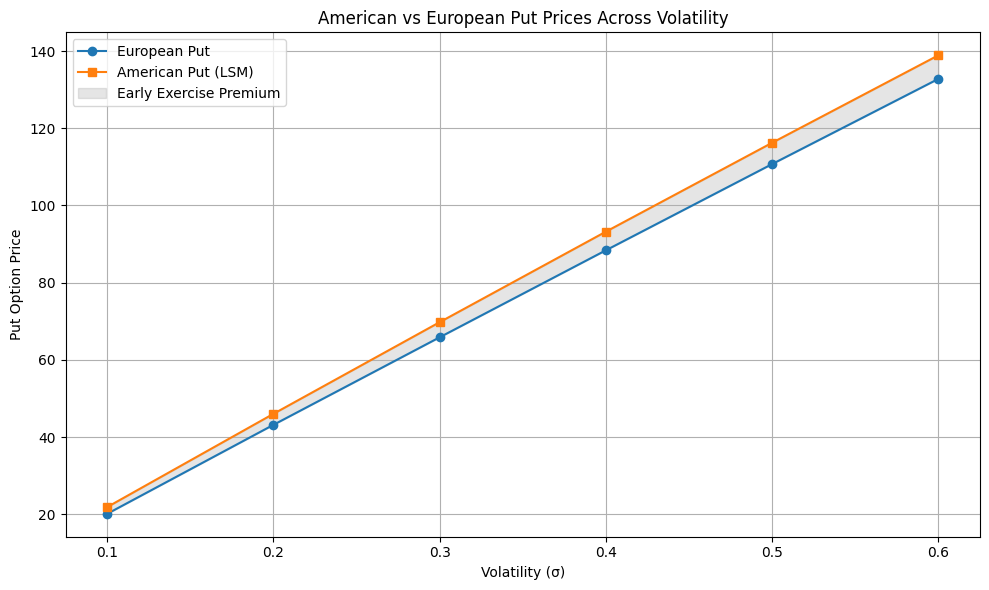

In [25]:
S0 = spy_data['Price'].iloc[-1]
S0 = S0.values[0]
K = 600
T = 1
r = 0.05
div_yield = 0.015
sim_rounds = 50000
time_slices = 252

# Range of volatilities to test
vol_range = np.linspace(0.1, 0.6, 6)

european_puts = []
american_puts = []

for sigma in vol_range:
    engine = MonteCarloOptionPricing(
        r=r,
        S0=S0,
        K=K,
        T=T,
        sigma=sigma,
        div_yield=div_yield,
        simulation_rounds=sim_rounds,
        no_of_slices=time_slices,
        fix_random_seed=True
    )

    engine.stock_price_simulation()
    european_puts.append(np.mean(engine.european_put()))
    american_puts.append(engine.american_option_longstaff_schwartz(poly_degree=2, option_type='put'))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(vol_range, european_puts, marker='o', label='European Put')
plt.plot(vol_range, american_puts, marker='s', label='American Put (LSM)')
plt.fill_between(vol_range, european_puts, american_puts, alpha=0.2, color='gray', label='Early Exercise Premium')
plt.xlabel('Volatility (σ)')
plt.ylabel('Put Option Price')
plt.title('American vs European Put Prices Across Volatility')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# **ANALYSIS**

# **REFERENCES**
[1] Glasserman, Monte Carlo Methods in Financial Engineering, Ch. 8

[2] Palczewski, Computational Finance Lecture Notes, Ch. 8

[3] McNeil, Frey, Embrechts, Quantitative Risk Management (for risk metrics background)

[4] “Valuing American Options by Simulation: A Simple Least-Squares Approach” Francis Longstaff and Eduardo Schwartz, Review of Financial Studies, 2001.